# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 06

**Author 1 (282304):** Yuanyuan Zheng  
**Author 2 (328992):** Ju Wu   
**Author 3 (307251):** Shuo Wen   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

#data_base_path = os.path.join(os.pardir, 'data')
#data_folder = 'lab-02-data'

from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/drive/My Drive/"
# base_dir=root_dir+'lab-01-data'
base_folder = root_dir + 'IAPR/lab-02-data'
data_base_path = os.path.join(os.pardir, 'data')

data_part1 = os.path.join(data_base_path, base_folder, 'part1')
data_part2 = os.path.join(data_base_path, base_folder, 'part2')

tar_path = os.path.join(data_base_path, base_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

base_dir=os.path.join(data_base_path, 'lab-02-data')
dp1=os.path.join(base_dir, 'part1')
dp2=os.path.join(base_dir, 'part2')
print(os.listdir(base_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['part1', 'part2']


---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

../data/lab-02-data/part1/0
../data/lab-02-data/part1/1


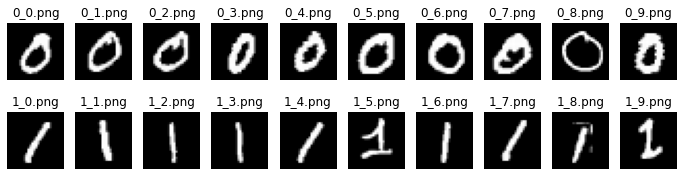

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit):
    digit_path = os.path.join(path, digit)
    print(digit_path)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                  
#  Load zeros and ones
zeros_im, zeros_names = load(dp1, '0')
ones_im, ones_names = load(dp1, '1')

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

#### 1.2.1 General concept of Fourier descriptor 

Sometimes, we can recognize an object or a pose of subject by its contour, for example, a cat and a person have different contours. Fourier descriptors is a way of encoding the contours. 
The idea is that, we can describe the closed-contour of object by calculating its Fourier transform, the result of Fourier transform allows us to decompose the contours into "frequencies": low frequencies for global geometry form, and high frequencies for more detailed geometry form. Thus, if 2 subjects have very distinguishable contours, we can easliy use the first low frequencies to differentiate them. In case that 2 objects are more or less similar, we may need some higher frequencies to observe these geometry forms in a more detailed way. 

#### 1.2.2 Procedure for implementation 

According to the definition of the Fourier descriptor, we need to calculate the Discrete Fourier transform (DFT) of the contour. The contour is composed by N succesive points of coordinates on a 2D plane, and these points of coordinates should be defined as complex numbers. Once the DFT is done, we can choose some significant frequencies and analyse them. 

Firstly, we will need to extract the contours for DFT. But as the writing digits have different thickness, and one image has some noise which will alter the extaction of contour (1_8.png), we need to proceed a preprocessing such as denoising for the image 1_8.png, and reducing the thickness of all the writing digits. "Erosion" and "thin" founctions seem to be quite effective. 
For the preprocessing part, we use "erosion" to remove the indesirable white edges on the image '1_8.png', then we apply a "thin"
fonction which will perform morphological thinning on all images, so that the thickness of writing digits are reduced to only one pixel, the contour extraction will be uniformly significant to all the images. 

After preprocessing, we use the "cv2.findContours" to extract contours of writing digits, and put them in the complex form. We observe that "zero" digits have 2 contours, and we choose the external contour by default with the parameter "cv2.RETR_EXTERNAL". Here is why the morphological thinning is interesting, because after thinning, the difference of 2 contours for "zero" digits is negligable, then the resulting fourrier descriptors will not be affected by the choice of contour. 

Once we obtain the complex-form of contours, we should calculate their FFT and their respective magnitude, we use directly the "fft" fonction and "abs" fonction in the "numpy" libary.

At the end, we choose the most significant Fourier descriptor and plot their resulting amplitudes of all images together. 

The detailled code of implementation can be found below.


In [3]:
from skimage.morphology import erosion,square,thin
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from PIL import Image
import cv2
import numpy as np
import numpy.fft
import random

selem = square(2)
ones_im[8] = erosion(ones_im[8], selem)  # preprocessing for removîng white edge in the image


In [4]:
# preprocessing : thin: reduce thinkness of writing digits into 1 pixel
def thin_images (zeros_images, ones_images):
    """
    Apply the morphological thinning on the images, so that the thickness of writing 
    digits will be reduced to only 1 pixel. This ia preprocessing part.

    arg: 
      original images of writing digits

    return:
      images after being thinned
      
    """
    zeros_im_copy = zeros_images.copy()
    zeros_thin=[]

    ones_im_copy = ones_images.copy()
    ones_thin=[]


    for im in zeros_im_copy:
        thresh = threshold_otsu(im)
        binary = im > thresh
        zeros_thin.append(thin(binary))

    for im in ones_im_copy:
        thresh = threshold_otsu(im)
        binary = im > thresh
        ones_thin.append(thin(binary))

    return zeros_thin,ones_thin

#def compute_dft(img,i,j,transformation = [rotation = None,scaling = None,translation = None],param = None): # param 
def compute_dft(img,i = 1,j = 2, rotation = False, scaling = False, translation = False):  
    """
    extract contour of image, apply an transformation on the contour if 
    necessary, compute FFT, then calculate the magnitude of FFT for given frequencies.

    arg: 
      img: preprocessed image
      i,j: 2 frequencies chosen, by default 1 and 2
      rotation, scaling, translation: options for transformation, False by default.

    return:
      amplitude of FFT for the given frequencies i,j divided by scaling factor (if scaling == True)
      amplitude of FFT for the given frequencies i,j (otherwise)

    """
    img = 255 * np.array(img).astype('uint8')
    contours, hierarchy = cv2.findContours(
        img,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contour_array = contours[0][:, 0, :]
    contour_complex = numpy.empty(contour_array.shape[:-1], dtype=complex)      # complex buffer for storing contours
    contour_complex_transformed = numpy.empty(contour_array.shape[:-1], dtype=complex) # complex buffer for storing transfored contours

    contour_complex.real=contours[0][:,0,0]
    contour_complex.imag=contours[0][:,0,1]
   
    if rotation == False and scaling == False and translation == False :
        contour_complex_transformed = contour_complex
      
    if rotation == True:
        angle=np.deg2rad(random.uniform(0,360)) # choose a random angle 
        rotation_matrix = np.array([[np.cos(angle),-1*np.sin(angle)],[np.sin(angle),np.cos(angle)]])
        rotate_result = rotation_matrix.dot(np.array([[contour_complex.real,contour_complex.imag]])) 
        rotated_complex = numpy.empty(contour_array.shape[:-1], dtype=complex)
        rotated_complex.real=rotate_result[0]
        rotated_complex.imag=rotate_result[1]
        contour_complex_transformed = rotated_complex
        
    if scaling == True:
        scaling_factor = random.randint(1,100)  # choose a random scaling factor
        scaled_contour_complex = contour_complex*scaling_factor
        contour_complex_transformed = scaled_contour_complex

        
    if translation == True:
        translated_contour_complex = numpy.empty(contour_array.shape[:-1], dtype=complex)
        offset_x = random.randint(1,100)  # choose random offset of coordinates
        offset_y = random.randint(1,100)
        translated_contour_complex.real = contour_complex.real+offset_x
        translated_contour_complex.imag = contour_complex.imag+offset_y
        contour_complex_transformed = translated_contour_complex

    fourier_result = numpy.fft.fft(contour_complex_transformed)
    fourier_power = np.abs(fourier_result)
        
    if scaling == True:
        return fourier_power[i]/scaling_factor,fourier_power[j]/scaling_factor,fourier_power/scaling_factor

    else:
        return fourier_power[i],fourier_power[j],fourier_power
    

def compute_dft_scope(img,i):
    img = 255 * np.array(img).astype('uint8')
    contours, hierarchy = cv2.findContours(
        img,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contour_array = contours[0][:, 0, :]
    contour_complex = numpy.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real=contours[0][:,0,0]
    contour_complex.imag=contours[0][:,0,1]

    fourier_result = numpy.fft.fft(contour_complex)
    fourier_power = np.abs(fourier_result)

    return fourier_power[0:i]/fourier_power[0]

def plot_result(zeros_thin, ones_thin, f1, f2,rotation = None,scaling = None,translation = None):
    A1=[]
    A2=[]

    for i in range (0,10,1):
        x_1,y_1,z_1=compute_dft(zeros_thin[i],f1,f2,rotation,scaling,translation)
        A1.append(x_1)
        A2.append(y_1)
        

    A3=[]
    A4=[]
    for i in range (0,10,1):
        x_0,y_0,z_0=compute_dft(ones_thin[i],f1,f2,rotation,scaling,translation)
        A3.append(x_0)
        A4.append(y_0)

    return A1,A2,A3,A4

#### 1.2.3 Demonstration of the invariance to rotation, translation and scaling

The Fourier transform is subject to the invariance to some transformations such as the rotation, translation and scaling. After some mathematical proves, we find that these transformations only affect the result of Fourier descriptors in certain ways: 
- Translation: Only affect DC component (frequency zero), not their phase.
- Rotation: Only affect the phase of all the Fourier descriptors, not their amplitude.
- Scaling: If the 2D shape is scaled (with respect to origin) by a factor S, its Fourier descriptor is also scaled by the same factor. 


In this section, we will try to show this invariance by ploting the results of Fourier descriptor magnitude with 2 first frequencies (f1 and f2). As we can see, the translation and the rotation will not change the magnitude of f1 and f2, and the scaling will scale the mangitude of f1 and f2 by a scaling factor. So we will plot the magnitude of f1 and f2 for the translation and rotation, and the magnitude of f1 and f2 divided by scaling factor for scaling transformation. If the implementation of Fourier descriptor is correct, we should get the same repartition of points on the plot, and the invariance can be demonstrated. 


In order to show the invariance in a convincing way, we will use the "random" libary to generate some random transformation parameters (i.e. offset for translation, angle for rotation and scaling factor for scaling). These transformations are not applied on the images, but directly on the extracted contours to avoid information loss due to transformation on the images.

The resulting plots are shown below. Here we have chosen the magnitude of f1 and f2. The result of the original images are shown on the first line, then we show the resulting plots of different transformation on the next lines. We apply for each transformation 2 times in order to avoid lucky concidences. We can conclude then the plots are the same, and it proves well the invariance. 


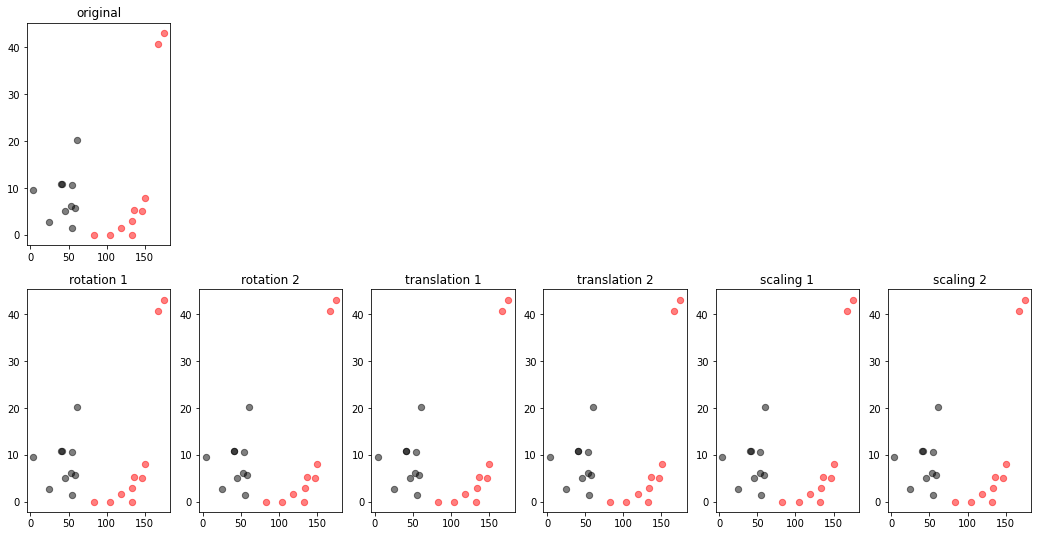

In [5]:
# original
zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
o_0_0,o_0_1,o_1_0,o_1_1 = plot_result(zeros_thin, ones_thin,1,2,False,False,False)

# rotation
eros_thin, ones_thin = thin_images(zeros_im,ones_im)
r_0_0_0,r_0_1_0,r_1_0_0,r_1_1_0 = plot_result(zeros_thin, ones_thin,1,2,True,False,False)

eros_thin, ones_thin = thin_images(zeros_im,ones_im)
r_0_0_1,r_0_1_1,r_1_0_1,r_1_1_1 = plot_result(zeros_thin, ones_thin,1,2,True,False,False)

# translation
zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
t_0_0_0,t_0_1_0,t_1_0_0,t_1_1_0 = plot_result(zeros_thin, ones_thin,1,2,False,False,True)

zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
t_0_0_1,t_0_1_1,t_1_0_1,t_1_1_1 = plot_result(zeros_thin, ones_thin,1,2,False,False,True)

# scaling
zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
s_0_0_0,s_0_1_0,s_1_0_0,s_1_1_0 = plot_result(zeros_thin, ones_thin,1,2,False,True,False)

zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
s_0_0_1,s_0_1_1,s_1_0_1,s_1_1_1 = plot_result(zeros_thin, ones_thin,1,2,False,True,False)



plt.figure(figsize=(18, 9)) 

plt.subplot(2, 6, 1)
plt.scatter(o_0_0,o_0_1,marker='o', s=40, c='black', alpha=0.5)
plt.scatter(o_1_0,o_1_1,marker='o', s=40, c='red', alpha=0.5)
plt.title('original')

plt.subplot(2, 6, 7)
plt.scatter(r_0_0_0,r_0_1_0, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(r_1_0_0,r_1_1_0, marker='o', s=40, c='red', alpha=0.5)
plt.title('rotation 1')


plt.subplot(2, 6, 8)
plt.scatter(r_0_0_1,r_0_1_1, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(r_1_0_1,r_1_1_1, marker='o', s=40, c='red', alpha=0.5)
plt.title('rotation 2')


plt.subplot(2, 6, 9)
plt.scatter(t_0_0_0,t_0_1_0, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(t_1_0_0,t_1_1_0, marker='o', s=40, c='red', alpha=0.5)
plt.title('translation 1')


plt.subplot(2, 6, 10)
plt.scatter(t_0_0_1,t_0_1_1, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(t_1_0_1,t_1_1_1, marker='o', s=40, c='red', alpha=0.5)
plt.title('translation 2')


plt.subplot(2, 6, 11)
plt.scatter(s_0_0_0,s_0_1_0, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(s_1_0_0,s_1_1_0, marker='o', s=40, c='red', alpha=0.5)
plt.title('scaling 1')


plt.subplot(2, 6, 12)
plt.scatter(s_0_0_1,s_0_1_1, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(s_1_0_1,s_1_1_1, marker='o', s=40, c='red', alpha=0.5)
plt.title('scaling 2')

plt.show()

### Discussion about Fourier descriptors:
If we only consider the writing digits for 0 (black points) and 1 (red points), we can see that the class "0" has a smaller intra-cluster distance and it's mostly on the left, the "1" has a higher intra-cluster distance (because of 2 images which have different form of writing compare to the others, namely 1_5.png and 1_9.png) and it's on the middle and right. The boundary of two classes with low frequencies (in our case f1 and f2) is more or less clear, we deduct that's because the contours of 0 and 1 are different enough.

However, in a more general way, if two classes of figures have similar contours, it will not be enough anymore to separate 2 classes with only 2 lower frequencies. 

In addition, in some cases, the DFT of contour will not be a good criteria to distinguish 2 objects, for example the writing digit "6" and "9", because the Fourier descriptors are invariant to the rotation, and the writing "6" and "9" has the same contours, they differ only by the rotation.

### 1.3 Additional method (5 pts)

In this part, based on the principle of the minimum reconstruction error, we employ the PCA pre-processing method first to compress the original images directly into feature vectors of dimension 2. And then as the comparison, we use the sequence of DFT norm with a range of frequencies obtained in Fourier descriptor method, in the following case, we select the length of Fourier descriptor sequence as 10.  

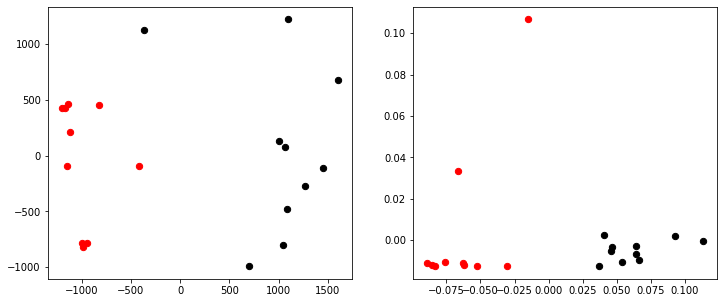

In [6]:
feature_vec_one=ones_im.reshape(10,-1)
feature_vec_zero=zeros_im.reshape(10,-1)
feature_vec=np.concatenate((feature_vec_zero,feature_vec_one),axis=0)
pca = PCA(n_components=2)
pca.fit(feature_vec)
y=pca.transform(feature_vec)
plt.figure(figsize=(12, 5)) 
plt.subplot(1,2,1)
plt.scatter(y[0:10,0],y[0:10,1],marker='o', s=40, c='black', alpha=1)
plt.scatter(y[10:20,0],y[10:20,1],marker='o', s=40, c='red', alpha=1)
plt.subplot(1,2,2)
zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
data_thin=np.concatenate((zeros_thin,ones_thin),axis=0)
data_fourier=[]
for i in range (0,20,1):
    fx=compute_dft_scope(data_thin[i],10)
    data_fourier.append(fx)
data_fourier=np.array(data_fourier)
y=pca.fit_transform(data_fourier)
plt.scatter(y[0:10,0],y[0:10,1],marker='o', s=40, c='black', alpha=1)
plt.scatter(y[10:20,0],y[10:20,1],marker='o', s=40, c='red', alpha=1)

We can observe that, with the sequence of DFT of a range of frequencies from Fourier descriptor, the separation performance surpasses the direct PCA on the original images. Then we select different lengths of DFT sequence to study the impact of its length on PCA method performance.

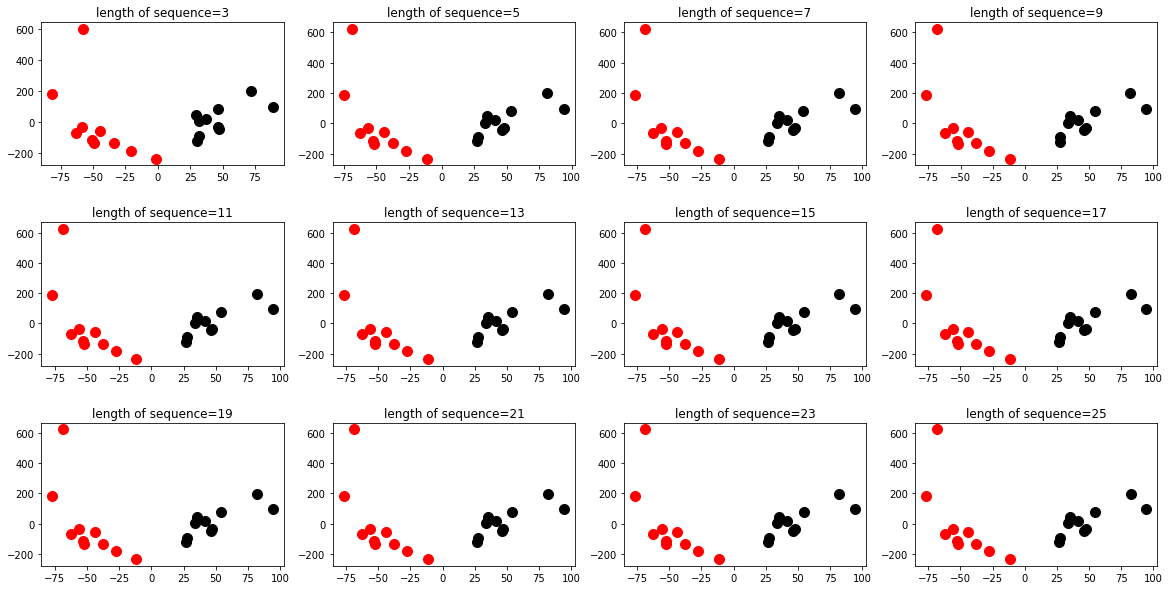

In [7]:
def plot_result_pca_len(zeros_thin, ones_thin, f1, f2,lens,rotation = None,scaling = None,translation = None):
    data_thin=np.concatenate((zeros_thin,ones_thin),axis=0)
    data_fourier=[]
    for i in range (0,20,1):
        x_0,y_0,z_0=compute_dft(data_thin[i],f1,f2,rotation,scaling,translation)
        
        fourier_s=z_0[0:lens]
        data_fourier.append(fourier_s)
    data_fourier=np.array(data_fourier)
    y=pca.fit_transform(data_fourier)
    return y
zeros_in, ones_in = thin_images(zeros_im,ones_im)
count = 0
plt.figure(figsize=(20, 10)) 
comb=[(False,False,False),(True,True,False),(True,False,True),(True,False,False),(False,True,True),(False,True,False),(False,False,True)
      ,(True,True,True)]
for i in range(3,27,2):
    count = count + 1
    # Here, for example, A2_f1 means the amplitude of twos of frequency f1
    y = plot_result_pca_len(zeros_in, ones_in,1,2,i,False,False,False)

    plt.subplot(3,4,count)
    plt.scatter(y[0:10,1],y[0:10,0], marker='o', s=100, c='black', alpha=1)
    plt.scatter(y[10:20,1],y[10:20,0], marker='o', s=100, c='red', alpha=1)
    plt.title(f'length of sequence={i}')

plt.subplots_adjust(hspace = 0.4)
plt.show()

We can observe that the difference of length of DFT sequence has negligible influence on the performance of PCA, which indicate the stability of Fourier descriptors representation ability for image features and the leading position of frequency pair 1&2. Then We do experiments the same as the above to demonstrate the invariance to rotation, translation and scaling. In the following experiments, to guarantee the redundancy of features and robustness against various image operations, we set the range of frequencies of DFT obtained from Fourier descriptors as 20. 

In [8]:
def plot_result_pca(zeros_thin, ones_thin, f1, f2,rotation = None,scaling = None,translation = None):
    data_thin=np.concatenate((zeros_thin,ones_thin),axis=0)
    data_fourier=[]
    for i in range (0,20,1):
        x_0,y_0,z_0=compute_dft(data_thin[i],f1,f2,rotation,scaling,translation)
        fourier_s=z_0[0:20]
        data_fourier.append(fourier_s)
    data_fourier=np.array(data_fourier)
    y=pca.fit_transform(data_fourier)
    return y

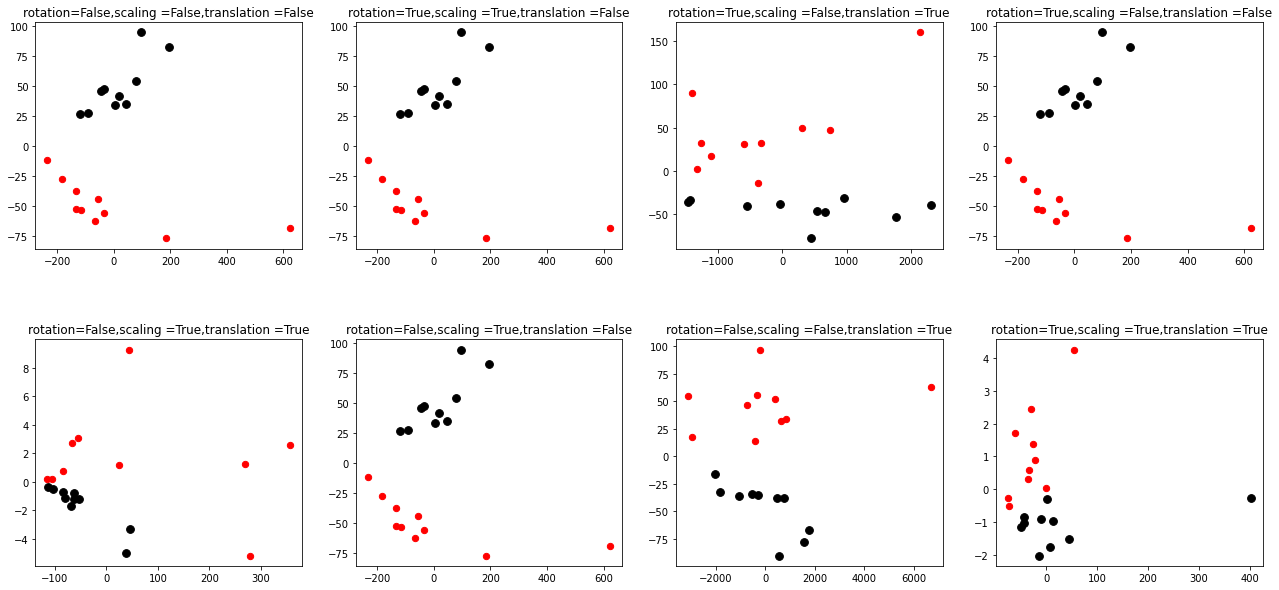

In [9]:
zeros_in, ones_in = thin_images(zeros_im,ones_im)
#zeros_in, ones_in = zeros_im,ones_im
count = 0
plt.figure(figsize=(22, 10)) 
comb=[(False,False,False),(True,True,False),(True,False,True),(True,False,False),(False,True,True),(False,True,False),(False,False,True)
      ,(True,True,True)]
for i in range(0,8):
    count = count + 1
    index=comb[i]
    y = plot_result_pca(zeros_thin, ones_thin,1,2,index[0],index[1],index[2])

    plt.subplot(2,4,count)
    plt.scatter(y[0:10,0],y[0:10,1], marker='o', s=60, c='black', alpha=1)
    plt.scatter(y[10:20,0],y[10:20,1], marker='o', s=40, c='red', alpha=1)
    plt.title(f'rotation={index[0]},scaling ={index[1]},translation ={index[2]}')

plt.subplots_adjust(hspace = 0.4)
plt.show()

###Discussion about PCA method
In virtue of the cascade of the output of Fourier descriptor and PCA preprocessing, we obtain relatively good performance of projecting two classes of digits into the opposite regions. We proves the leading position of frequency pair 1&2 in the feature obtained by Fourier descriptor via PCA's embedding. And we can observe that compared to employing solely values from a pair of frequencies, the usage of values from a range of frequencies decrease the intra-cluster distance and increase the robustness against image operations such as translation, rotation and scaling.    

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

../data/lab-02-data/part2/2
../data/lab-02-data/part2/3


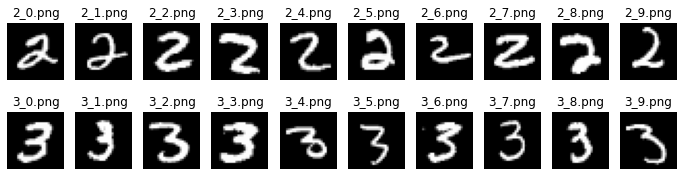

In [10]:
# Load twos and threes
twos_im, twos_names = load(dp2, digit='2')
threes_im, threes_names = load(dp2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In this section, the color black, red, green, and blue represent the digit '0', '1', '2', and '3' respectively.

#### 2.2.1 Discriminate '2' and '3'

First, we find the 2D feature vector which is used to discriminate digit '2' and '3' by traversing the combinations between the first 9 frequencies. (We only consider the first 9 frequencies since we find the average power decreases with the increaseing of frequency, and the 9th frequency is already very low. Thus, we do not consider the higher frequencies.)

In [11]:
def plot_result_two_digits_2D(twos_thin, threes_thin, f1, f2):
    """
    arg: 
      twos_thin: contour of twos
      threes_thin: contour of threes
      f1, f2: 2 chosen frequencies

    return:
      A1,A2: amplitude of DFT of twos for the given frequencies f1, f2
      A3,A4: amplitude of DFT of threes for the given frequencies f1, f2
    """

    A1=[]
    A2=[]
    for i in range (0,10,1):
        # function compute_dft is defined in part 1.2, and it only returns the amplitude of DFT
        x_2,y_2,_=compute_dft(twos_thin[i],f1,f2)
        A1.append(x_2)
        A2.append(y_2)

    A3=[]
    A4=[]
    for i in range (0,10,1):
        x_3,y_3,_=compute_dft(threes_thin[i],f1,f2)
        A3.append(x_3)
        A4.append(y_3)

    return A1,A2,A3,A4

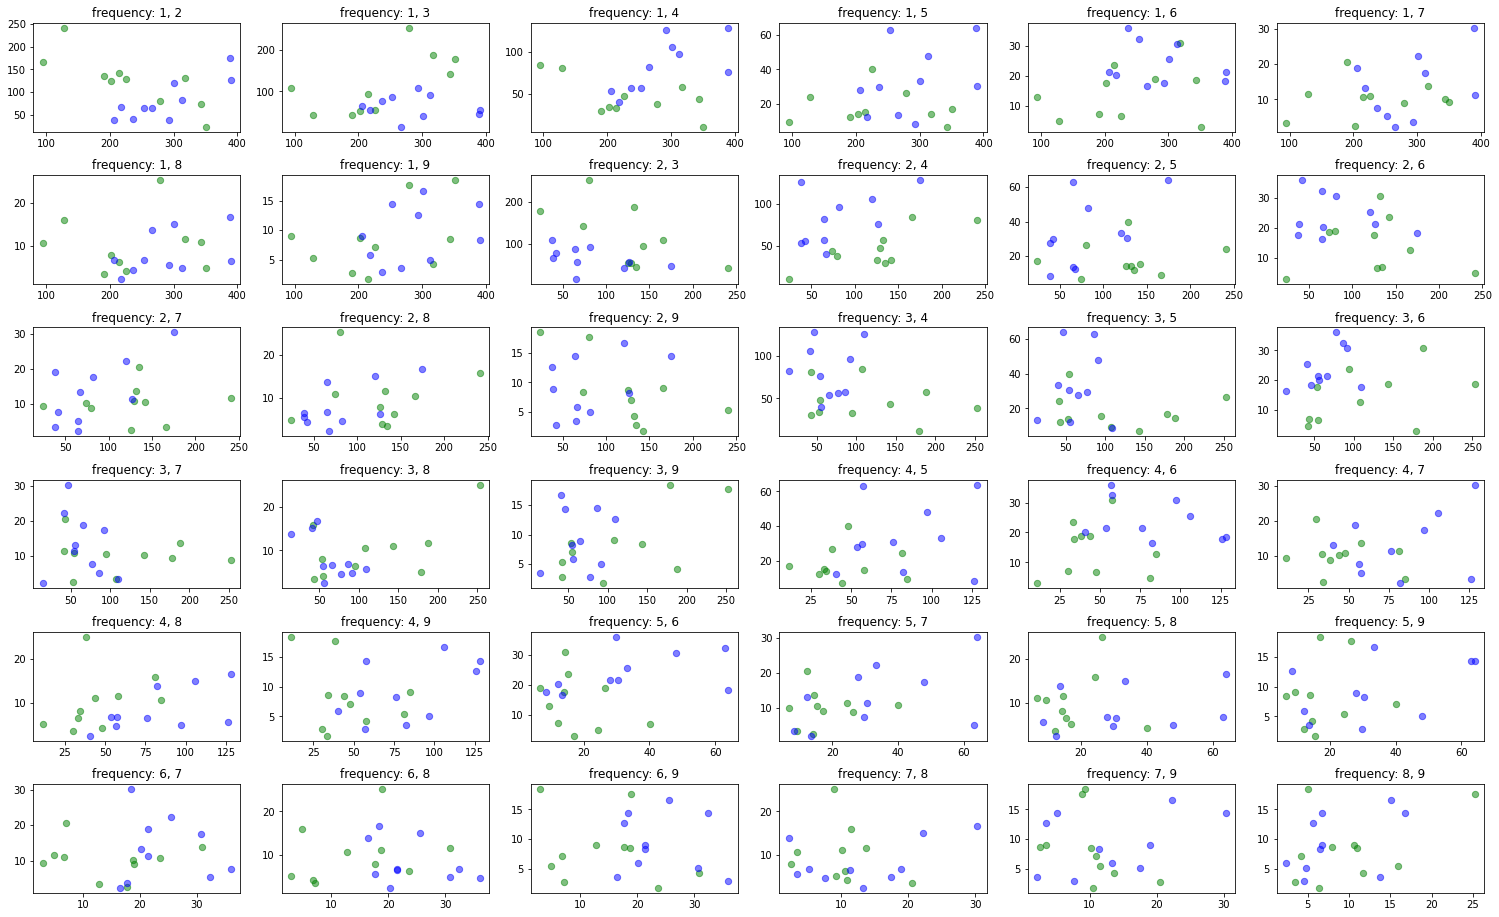

In [12]:
# Get the contours of twos and threes
twos_thin, threes_thin = thin_images(twos_im,threes_im)
count = 0
plt.figure(figsize=(26, 16)) 

for i in range(1,10):
    for j in range(i+1,10):
        count = count + 1

        # Here, for example, A2_f1 means the amplitude of twos of frequency f1
        A2_f1, A2_f2, A3_f1, A3_f2 = plot_result_two_digits_2D(twos_thin, threes_thin, i, j)

        plt.subplot(6,6,count)
        plt.scatter(A2_f1,A2_f2, marker='o', s=40, c='green', alpha=0.5)
        plt.scatter(A3_f1,A3_f2, marker='o', s=40, c='blue', alpha=0.5)
        plt.title(f'frequency: {i}, {j}')

plt.subplots_adjust(hspace = 0.4)
plt.show()

From the results we see that many 2D feature vectors perform well. Among them, the 2D feature vector consists of the 2nd and 4th frequencies has the best performance, an the result figure is shown below:

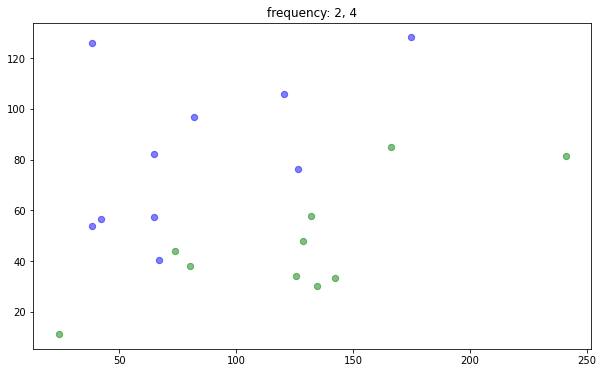

In [13]:
A2_f1, A2_f2, A3_f1, A3_f2 = plot_result_two_digits_2D(twos_thin, threes_thin, 2, 4)

plt.figure(figsize=(10, 6)) 
plt.scatter(A2_f1,A2_f2, marker='o', s=40, c='green', alpha=0.5)
plt.scatter(A3_f1,A3_f2, marker='o', s=40, c='blue', alpha=0.5)
plt.title('frequency: 2, 4')
plt.show()

#### 2.2.2 Discriminate four digits using a 2D feature vector

In this section, we try to find the 2D feature vector which is used to discriminate all the four digits. For the same reason as in the previous section, we still find the 2D vector by traversing the combinations between the first 9 frequencies.

In [14]:
def plot_result_four_digits_2D(zeros_thin, ones_thin, twos_thin, threes_thin, f1, f2):
    """
    arg: 
      zeros_thin: contour of zeros
      ones_thin: contour of ones
      twos_thin: contour of twos
      threes_thin: contour of threes
      f1, f2: 2 chosen frequencies

    return:
      A1,A2: amplitude of DFT of zeros for the given frequencies f1, f2
      A3,A4: amplitude of DFT of ones for the given frequencies f1, f2
      A5,A6: amplitude of DFT of twos for the given frequencies f1, f2
      A7,A8: amplitude of DFT of threes for the given frequencies f1, f2
    """

    A1=[]
    A2=[]
    for i in range (0,10,1):
        x_0,y_0,_=compute_dft(zeros_thin[i],f1,f2)
        A1.append(x_0)
        A2.append(y_0)

    A3=[]
    A4=[]
    for i in range (0,10,1):
        x_1,y_1,_=compute_dft(ones_thin[i],f1,f2)
        A3.append(x_1)
        A4.append(y_1)

    A5=[]
    A6=[]
    for i in range (0,10,1):
        x_2,y_2,_=compute_dft(twos_thin[i],f1,f2)
        A5.append(x_2)
        A6.append(y_2)
    A7=[]
    A8=[]
    for i in range (0,10,1):
        x_3,y_3,_=compute_dft(threes_thin[i],f1,f2)
        A7.append(x_3)
        A8.append(y_3)

    return A1,A2,A3,A4,A5,A6,A7,A8

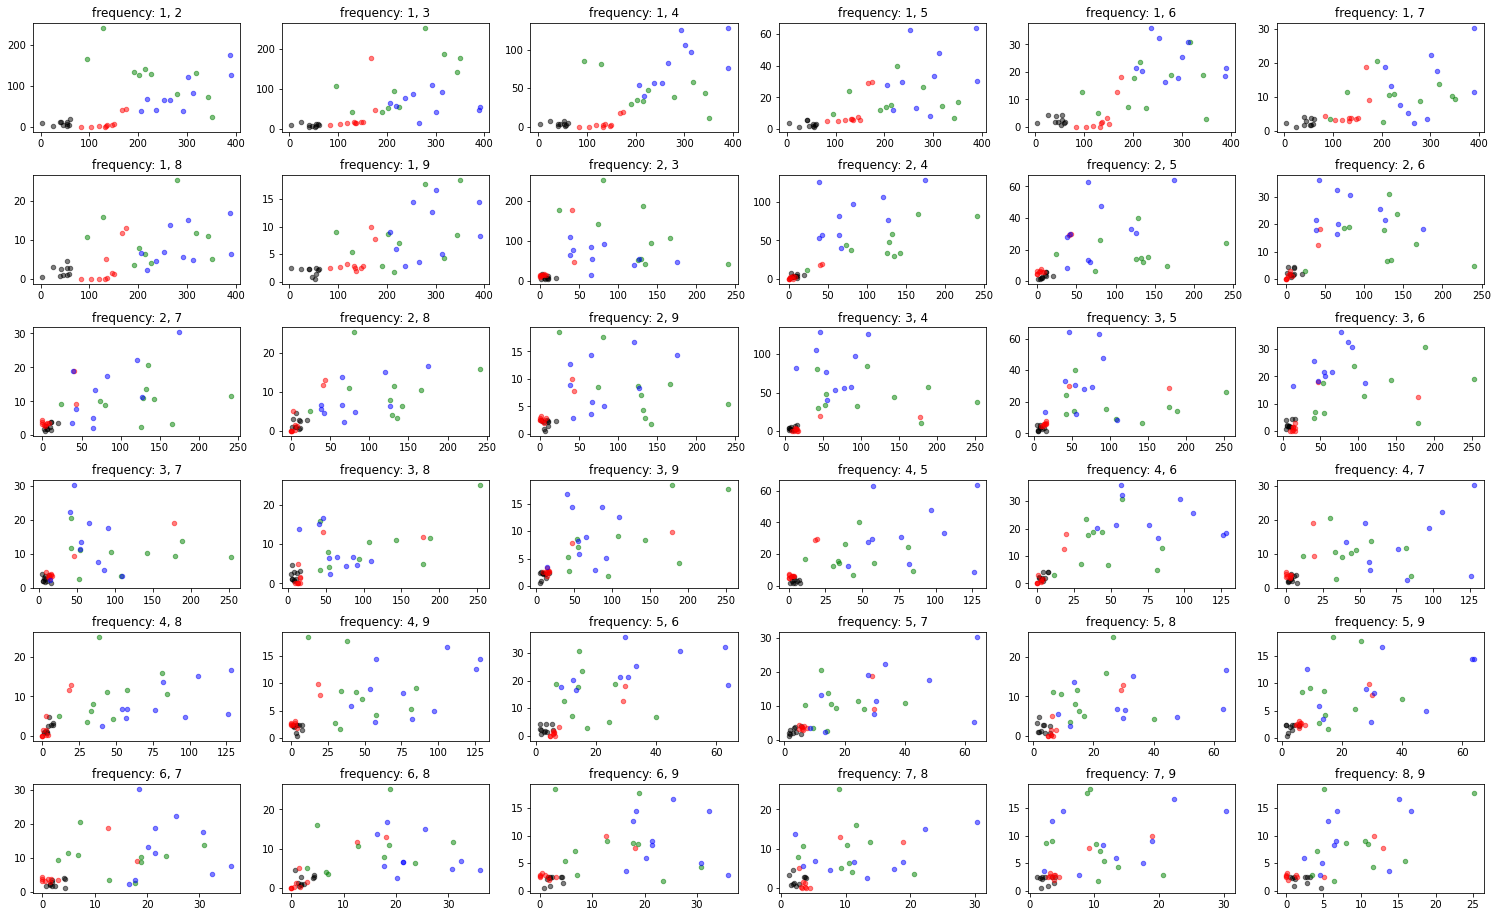

In [15]:
# Get the contours of the four digits
zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
twos_thin, threes_thin = thin_images(twos_im,threes_im)

count = 0
plt.figure(figsize=(26, 16)) 

for i in range(1,10):
    for j in range(i+1,10):
        count = count + 1

        # Here, for example, A0_f1 means the amplitude of zeros of frequency f1
        A0_f1, A0_f2, A1_f1, A1_f2, A2_f1, A2_f2, A3_f1, A3_f2 = plot_result_four_digits_2D(zeros_thin, ones_thin, twos_thin, threes_thin, i, j)

        plt.subplot(6,6,count)
        plt.scatter(A0_f1,A0_f2, marker='o', s=20, c='black', alpha=0.5)
        plt.scatter(A1_f1,A1_f2, marker='o', s=20, c='red', alpha=0.5)
        plt.scatter(A2_f1,A2_f2, marker='o', s=20, c='green', alpha=0.5)
        plt.scatter(A3_f1,A3_f2, marker='o', s=20, c='blue', alpha=0.5)
        plt.title(f'frequency: {i}, {j}')

plt.subplots_adjust(hspace = 0.4)
plt.show()

From the result we see that it is hard to discriminate all these 4 digits with a 2-dimensional feature vector. The reason is: '0' and '1' are discriminated better by 2-dimensional feature vector of low frequencies, while '2' and '3' are discriminated better by 2-dimensional feature vector of high frequencies. For example, the 1st frequency discriminates '0' and '1' well but cannot  discriminate '2' and '3'; the 2D feature consist of the 2nd and 4th frequencies discriminates '2' and '3' well but cannot  discriminate '0' and '1'. The figures are shown below:

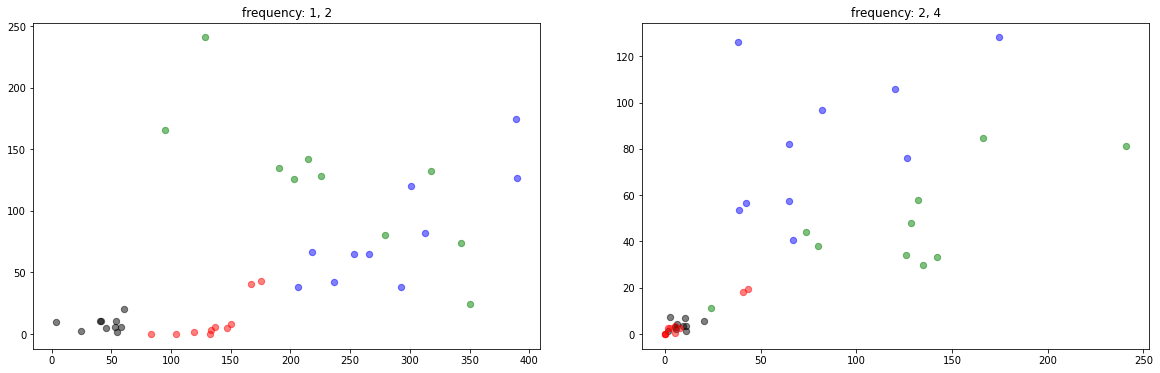

In [16]:
plt.figure(figsize=(20, 6)) 

A0_f1, A0_f2, A1_f1, A1_f2, A2_f1, A2_f2, A3_f1, A3_f2 = plot_result_four_digits_2D(zeros_thin, ones_thin, twos_thin, threes_thin, 1, 2)

plt.subplot(1,2,1)
plt.scatter(A0_f1,A0_f2, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(A1_f1,A1_f2, marker='o', s=40, c='red', alpha=0.5)
plt.scatter(A2_f1,A2_f2, marker='o', s=40, c='green', alpha=0.5)
plt.scatter(A3_f1,A3_f2, marker='o', s=40, c='blue', alpha=0.5)
plt.title('frequency: 1, 2')

A0_f1, A0_f2, A1_f1, A1_f2, A2_f1, A2_f2, A3_f1, A3_f2 = plot_result_four_digits_2D(zeros_thin, ones_thin, twos_thin, threes_thin, 2, 4)

plt.subplot(1,2,2)
plt.scatter(A0_f1,A0_f2, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(A1_f1,A1_f2, marker='o', s=40, c='red', alpha=0.5)
plt.scatter(A2_f1,A2_f2, marker='o', s=40, c='green', alpha=0.5)
plt.scatter(A3_f1,A3_f2, marker='o', s=40, c='blue', alpha=0.5)
plt.title('frequency: 2, 4')
plt.show()

However, even if we cannot find the 2D feature vector which is able to discriminate the four digits at the same time, we can separate the four digits in **two steps**. Specifically: 

1. Frist we use the 1st and 4th frequenies to find which group the digits belong to, group '0 or 1' or group '2 or 3'.
2. Then in group '0 or 1', we use the 1st and 2nd frequenies to discriminate '0' and '1'; in group '2 or 3', we use the 2nd and 4th frequenies to discriminate '2' and '3'

First, separate '0','1' and '2','3' using the 1st and 4th frequenies:

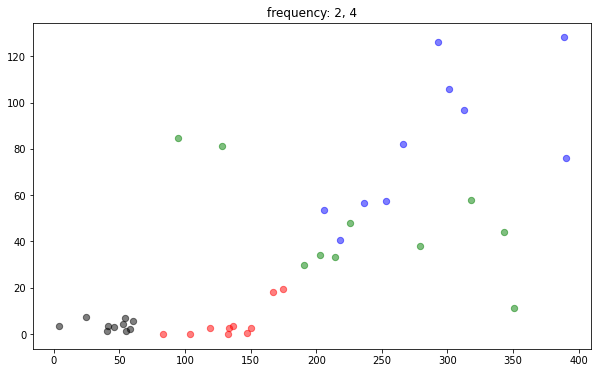

In [17]:
A0_f1, A0_f2, A1_f1, A1_f2, A2_f1, A2_f2, A3_f1, A3_f2 = plot_result_four_digits_2D(zeros_thin, ones_thin, twos_thin, threes_thin, 1, 4)

plt.figure(figsize=(10, 6)) 
plt.scatter(A0_f1,A0_f2, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(A1_f1,A1_f2, marker='o', s=40, c='red', alpha=0.5)
plt.scatter(A2_f1,A2_f2, marker='o', s=40, c='green', alpha=0.5)
plt.scatter(A3_f1,A3_f2, marker='o', s=40, c='blue', alpha=0.5)
plt.title('frequency: 2, 4')
plt.show()

Then, separate '0' and '1' using the 1st and 2nd frequenies, and separate '2' and '3' using the 2nd and 4th frequenies.

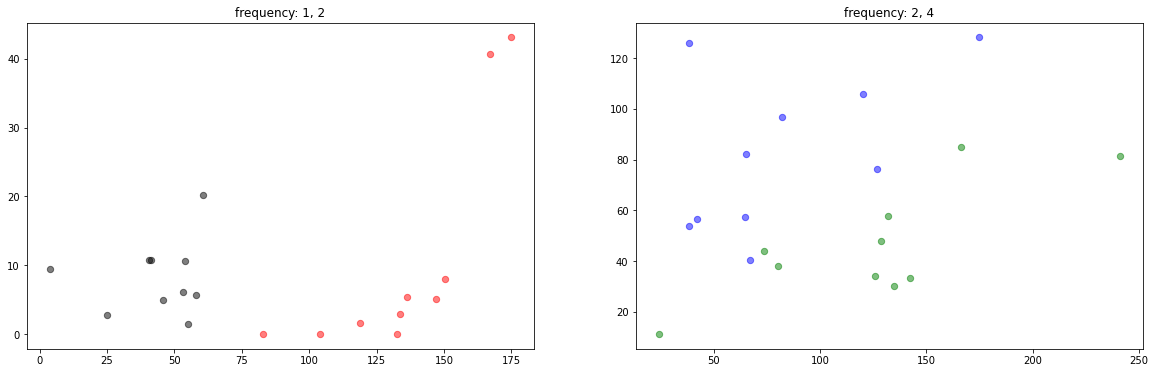

In [18]:
plt.figure(figsize=(20, 6)) 

A0_f1, A0_f2, A1_f1, A1_f2 = plot_result_two_digits_2D(zeros_thin, ones_thin, 1, 2)

plt.subplot(1,2,1)
plt.scatter(A0_f1,A0_f2, marker='o', s=40, c='black', alpha=0.5)
plt.scatter(A1_f1,A1_f2, marker='o', s=40, c='red', alpha=0.5)
plt.title('frequency: 1, 2')

A2_f1, A2_f2, A3_f1, A3_f2 = plot_result_two_digits_2D(twos_thin, threes_thin, 2, 4)

plt.subplot(1,2,2)
plt.scatter(A2_f1,A2_f2, marker='o', s=40, c='green', alpha=0.5)
plt.scatter(A3_f1,A3_f2, marker='o', s=40, c='blue', alpha=0.5)
plt.title('frequency: 2, 4')
plt.show()

#### 2.2.3 Discriminate four digits with the help of PCA

In the previous sections, for each dimension of the 2D feature vector, we set it as the amplitute of the n-th frequency. However, we can also set each dimension of the 2D vector as a **linear combination** of the amplitute of several different frequencies. In this section, we use PCA to find two linear combinations of the frequencies, and treat the two linear combinations of frequencies as the 2D feature vector. The result is shown below:

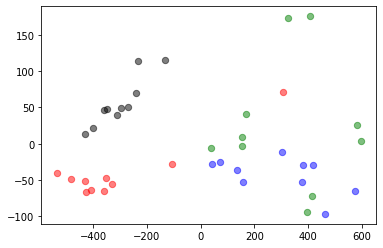

In [19]:
zeros_thin, ones_thin = thin_images(zeros_im,ones_im)
twos_thin, threes_thin = thin_images(twos_im,threes_im)
data_thin=np.concatenate((zeros_thin,ones_thin,twos_thin,threes_thin),axis=0)
data_fourier=[]
for i in range (0,40,1):
    x,y,z=compute_dft(data_thin[i],1,2)
    data_fourier.append(z[0:15])
data_fourier=np.array(data_fourier)
y=pca.fit_transform(data_fourier)
plt.scatter(y[0:10,0],y[0:10,1],marker='o', s=40, c='black', alpha=0.5)
plt.scatter(y[10:20,0],y[10:20,1],marker='o', s=40, c='red', alpha=0.5)
plt.scatter(y[20:30,0],y[20:30,1],marker='o', s=40, c='green', alpha=0.5)
plt.scatter(y[30:40,0],y[30:40,1],marker='o', s=40, c='blue', alpha=0.5)

From the result we see that even if we use linear combination of the amplitute of several different frequencies, it is still hard to discriminate the four digits. The reason might be that even if each dimension of the 2D feature vector is a linear combination of different frequencies, it is still dominated by high or low frequencies. As we discussed before, '0' and '1' are discriminated better by vector of low frequencies, while '2' and '3' are discriminated better by vector of high frequencies. Thus, it is still hard to discriminate the four digits in 2D even if we  use linear combination of frequencies as the feature vector.

#### Conclusion

1. It is hard to discriminate all these 4 digits with a 2-dimensional feature vector, since '0' and '1' are discriminated better by 2-dimensional feature vector of low frequencies, while '2' and '3' are discriminated better by 2-dimensional feature vector of high frequencies. Even if we use PCA to find two linear combinations of the frequencies and treat them as the 2D feature vector, it is still hard to discriminate all these 4 digits for the same reason as before.

2. Fourier descriptor still performs well on extracting the features. On one hand, even if there are some cases which are hard to discriminated, we can still see a rough separation between the four digits. On the other hand, we can use the two step method to get a good separation, which means the feature obtained by Fourier descriptor is useful.